# Исследование заномерностей, определяющих успешность компьютерной игры

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. 

**Цель исследования:**

Выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Нужно отработать принцип работы с данными, вне зависимости от года исследования.


## Изучение данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import statistics
import seaborn as sns
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

In [2]:
# применим метод set_option для отображения всех столбцов
pd.set_option('mode.chained_assignment', None)

In [3]:
# загрузим таблицу
try:
    df = pd.read_csv('/datasets/games.csv')
except:
    df = pd.read_csv('games.csv')

In [4]:
df.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
12368,Mirror's Edge Catalyst,PC,2016.0,Platform,0.01,0.05,0.00,0.00,74.0,4.4,T
802,Final Fantasy III,DS,2006.0,Role-Playing,0.89,0.04,1.07,0.09,77.0,7.1,E10+
9222,RockMan & Forte,SNES,1998.0,Platform,0.00,0.00,0.14,0.00,NaN,NaN,NaN
10926,Ribbit King,PS2,2003.0,Sports,0.05,0.04,0.00,0.01,58.0,6.5,E
2944,Minecraft: Story Mode,PS3,2015.0,Adventure,0.27,0.31,0.00,0.11,NaN,NaN,NaN


Таблица выглядит корректно. Посмотрим на общую информацию о данных.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В таблице 11 столбцов. Согласно документации к данным:
* `Name`— название игры
* `Platform` — платформа
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score` — оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

### Вывод

* Есть нарушения стиля в названиях столбцов (названия записаны в верхнем регистре)
* В некоторых столбцах присутствуют пропуски
* Столбцы `Year_of_Release` и `User_Score` имеют неверный тип данных

Перед началом исследования необходимо исправить данные недочеты.


## Предобработка данных

Необходимо выполнить следующие шаги:
* Привести названия столбцов к стилистически верному виду
* произвести обработку пропусков
* Привести данные в столбцах к верному типу данных
* Посчитать суммарные продажи во всех регионах и записать их в отдельный столбец.

### Исправление названий столбцов

Названия столбцов написаны в верхнем регистре. Переведем их в нижний регистр с помощью метода строк *lower()*

In [6]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Обработка пропусков

In [7]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

* `name` - 2 пропуска. Причины пропусков неясны. Так как пропусков очень мало можно ими пренебречь и удалить эти строки.
* `year_of_release` - 269 пропусков. Возможна ошибка в открытых источниках. Пропусков немного, но удалять строки не будем, т.к. они могут содержать полезную информацию в других столбцах.
* `critic_score` - 8578 пропусков. Не все игры были оценены критиками. удалять пропуски нельзя (много ценной информации в других столбцах). Замена пропусков также неприемлима, т.к. очень исказит выводы. Оставим без изменений.
* `user_score` - 6701 пропуск. Причины и действия те же.
* `rating` - 6766 пропусков. Причины и действия те же.

In [8]:
# удаление строк с пропусками в столбце "name"
df = df.dropna(subset=['name'])

### Замена типов данных

Столбцы, в которых нужно заменить тип данных:
* `year_of_release` - необходимый тип данных - *int* (хоть это и столбец с датой, у нас дан только год, а тип данных *datetime* предполагает наличие нескольких временных составляющих)
* `user_score` - необходимый тип данных - *float*

In [9]:
# столбец "year_of_release" приведем к целочисленному типу
df['year_of_release'] = df['year_of_release'].astype('Int64')

Столбец `user_score` имеет тип *object*. Нужно проверить в чем причина.

In [10]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Столбец содержит значение 'tbd'. TBD - аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено). Используется, если какая-то информация еще не определена или решение по вопросу не принято.

Другими словами это пропуски, поэтому приведем их к типу NaN а затем приведем столбец к типу *float*.


<div class="alert alert-success">
<b>✔️ Комментарий ревьюера:</b> Правльное решение..</div>

In [11]:
# заменим 'tbd' на NaN
df.loc[df['user_score'] == 'tbd', 'user_score'] = np.nan
# приведем к типу float
df['user_score'] = df['user_score'].astype('float')
df['user_score'].dtypes

dtype('float64')

### Подсчет суммарных продаж во всех регионах

In [12]:
# создадим столбец "total_sales" и расположим его после столбцов с продажами
df.insert(8, 'total_sales', df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales'])
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,82.54,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,35.52,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,32.77,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,31.38,NaN,NaN,NaN


### Вывод

В данном разделе были проведены исправление названий столбцов, замена типов данных, обработка пропусков а также произведен подсчет суммарных продаж во всех регионах. Можно приступать к исследованию.

## Исследовательский анализ данных

### Количество выпускаемых игр в разные периоды

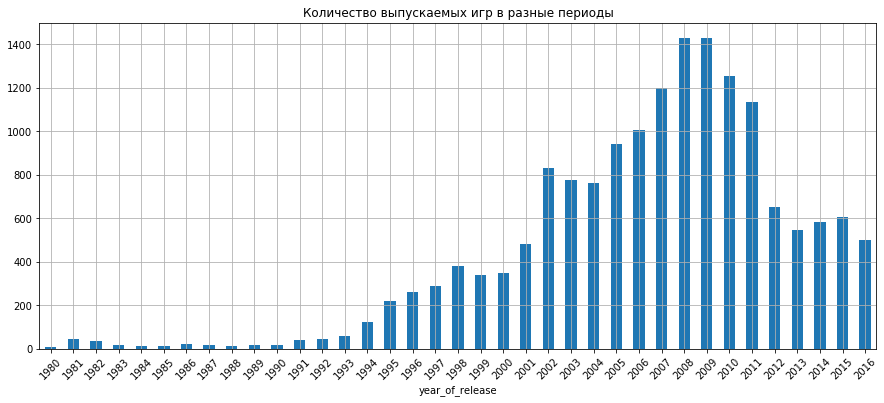

In [13]:
# создадим сводную таблицу с количеством игр по годам и построим столбчатую диаграмму
df.pivot_table(index='year_of_release', values='name', aggfunc='count').plot.bar(figsize=(15, 6), 
                                                                                 rot=45, 
                                                                                 grid=True, 
                                                                                 legend=False
                                                                                )
plt.title('Количество выпускаемых игр в разные периоды')
plt.show()

Из диаграммы видно что до 1995 года каждый год выпускалось всего несколько десятков игр. После 1995 года шел плавный рост с пиком в 2008-2009 годах (около 3000 игр за эти два года). После чего было плавное снижение до 2011 года включительно и резкий спад после 2011 года. С 2012 года график находтся в боковике.<br>
Так как до 1995 года количество игр было незначительно эти данные можно не учитывать.

In [14]:
df_95 = df.query('year_of_release >= 1995')

### Динамика продаж

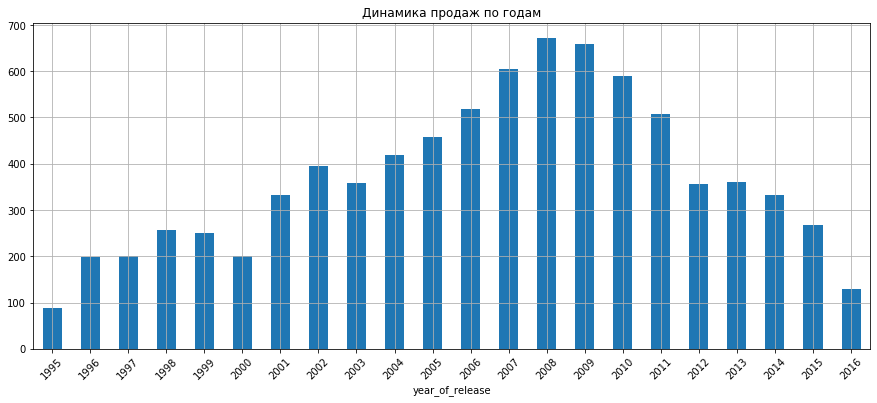

In [15]:
# посмотрим на динамику продаж по годам
df_95.pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot.bar(figsize=(15, 6), 
                                                                                 rot=45, 
                                                                                 grid=True, 
                                                                                 legend=False
                                                                                )
plt.title('Динамика продаж по годам')
plt.show()

C 1995 начался последовательный рост с пиком в 2008 году (более 650 миллионов копий) и таким же плавным спадом до настоящего времени.

Теперь рассмотрим топовые платформы по количеству продаж.

In [16]:
df_95.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values('total_sales', ascending=False)

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.76
PS,721.55
PS4,314.14
GBA,312.88
PSP,289.53


Можно выделить шестерку лидеров, так как после *PS* идет двухкратный спад по продажам.

In [17]:
# создадим сводную таблицу с топ-платформами
df_top = df_95[df_95['platform'].isin(('PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS'))]\
                          .pivot_table(index=['platform', 'year_of_release'], values='total_sales', aggfunc='sum')\
                          .reset_index()
df_top.head(10)

,platform,year_of_release,total_sales
0,DS,2004,17.27
1,DS,2005,130.14
2,DS,2006,119.81
3,DS,2007,146.94
4,DS,2008,145.31
5,DS,2009,119.54
6,DS,2010,85.02
7,DS,2011,26.18
8,DS,2012,11.01
9,DS,2013,1.54


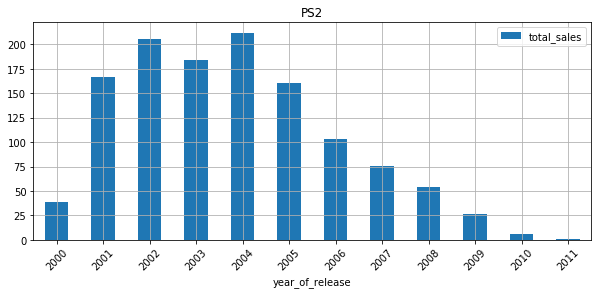

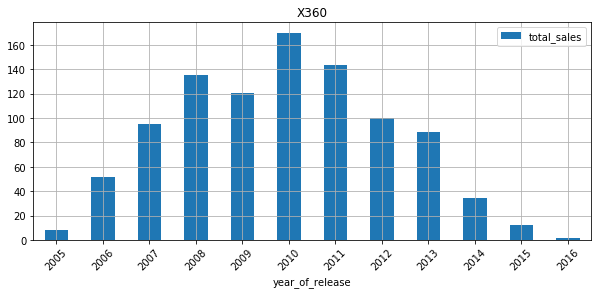

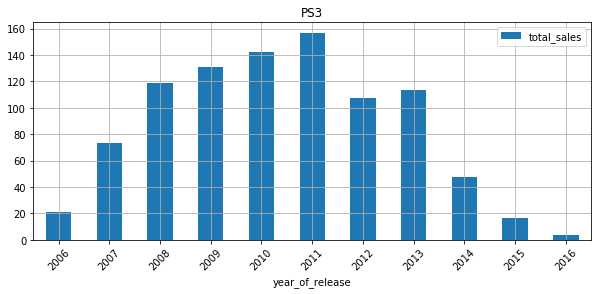

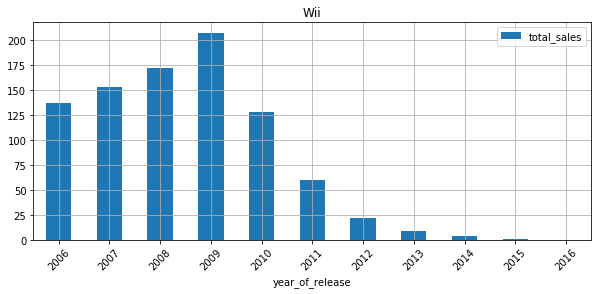

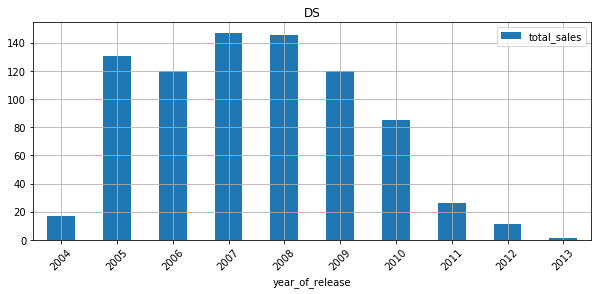

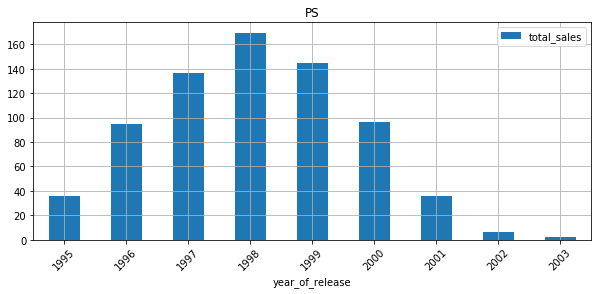

In [18]:
# с помощью цикла построим столбчатые диаграммы с продажами по годам для топ-платформ
lst = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']
for i in lst:
    (df_top[df_top['platform'] == i]
     .plot.bar('year_of_release', 
               'total_sales', 
               figsize=(10,4), 
               title=i, 
               grid=True, 
               rot=45)
    )
plt.show()

Из диаграмм видно, что они в основном имеют близкое к нормальному распределение. Можно сказать что платформы имеют определенный цикл роста и падения, другими словами "продолжительности жизни" платформы.

### За какой характерный срок появляются новые и исчезают старые платформы?

Большинство диаграмм имеют нормальное распределение по продажам. По ним видно цикл жизни платформы. Рассчитаем среднюю "продолжительность жизни" платформ.

In [19]:
# выделим платформы, которые уже прошли полный цикл (от старта продаж до их прекращения)
dead_platforms = (df.pivot_table(index='platform', values='year_of_release', aggfunc='max')
                  .query('year_of_release != 2016')
                  .index
                 )
dead_platforms

Index(['2600', '3DO', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG', 'N64', 'NES',
       'NG', 'PCFX', 'PS', 'PS2', 'PSP', 'SAT', 'SCD', 'SNES', 'TG16', 'WS',
       'XB'],
      dtype='object', name='platform')

In [20]:
# найдем медианную "продолжительность жизни" платформы
mean_life = []
for i in dead_platforms:
    platform_life = (df[df['platform'] == i]['year_of_release'].max() - df[df['platform'] == i]['year_of_release'].min())
    mean_life.append(platform_life)

print(f'Средняя продолжительность жизни платформы составляет {statistics.mean(mean_life)} лет.')

Средняя продолжительность жизни платформы составляет 7 лет.


Теперь попробуем найти медианное время роста платформы до пиковых показателей продаж.

In [21]:
# сводная таблица с годовыми продажами
peak = df.pivot_table(index=['platform', 'year_of_release'], values='total_sales', aggfunc='sum').reset_index()
peak.head()

,platform,year_of_release,total_sales
0,2600,1980,11.38
1,2600,1981,35.68
2,2600,1982,28.88
3,2600,1983,5.84
4,2600,1984,0.27


In [22]:
# начало продаж
start_life = df.groupby('platform')[['year_of_release']].min().reset_index()
# берем только платформы полного цикла
start_life = start_life.query('platform in @dead_platforms')
start_life.sample(5)

,platform,year_of_release
23,SNES,1990
1,3DO,1994
24,TG16,1995
11,NES,1983
9,GG,1992


In [23]:
# находим наибольшее количество продаж по каждой платформе в определенный год
peak_life = peak.groupby('platform')[['total_sales']].max().reset_index()
peak_life.sample(5)

,platform,total_sales
6,GBA,77.91
28,X360,170.03
29,XB,65.42
22,SCD,1.50
9,GG,0.04


In [24]:
# объединяем таблицы
peak_life = peak_life.merge(peak, how='inner')
peak_life = peak_life.rename(columns={'year_of_release':'peak_year'})
# берем только платформы полного цикла
peak_life = peak_life.query('platform in @dead_platforms')
peak_life.head()

,platform,total_sales,peak_year
0,2600,35.68,1981
1,3DO,0.08,1995
3,DC,5.99,2000
4,DS,146.94,2007
5,GB,64.97,1989


In [25]:
# объединяем таблицы
peak_life = peak_life.merge(start_life)
peak_life['growth_time'] = peak_life['peak_year'] - peak_life['year_of_release']
peak_life.sample(5)

,platform,total_sales,peak_year,year_of_release,growth_time
20,WS,0.68,2000,1999,1
17,SCD,1.50,1993,1993,0
12,PCFX,0.03,1996,1996,0
7,GEN,12.64,1992,1990,2
4,GB,64.97,1989,1988,1


In [26]:
print(f'Среднее время роста платформы до пиковых показателей продаж составляет {peak_life["growth_time"].mean():.0f} года.')

Среднее время роста платформы до пиковых показателей продаж составляет 3 года.


### Промежуточный вывод исследования

В данном разделе мы отсекли годы с небольшим количеством продаж (до 1995г.). По диаграммам распределения продаж по годам по топ-платформам  было выявлено, что платформы имеют определенный цикл "продолжительность жизни" и в результате расчетов определено, что средняя **"продолжительность жизни"** платформы составляет **7 лет**, а среднее **время роста** платформы до пиковых показателей продаж составляет **3 года**.

Также было выяснено что с 2008 года идет серьезный спад продаж.

### Выбор актуального периода

За актуальный период выберем среднее время роста платформы до пиковых показателей продаж, т.е. 3 года.

In [27]:
df_actual = df.query('year_of_release >= 2014')
df_actual['year_of_release'].nunique()

3

In [28]:
print(f'Количество платформ: {df_actual["platform"].nunique()}')

Количество платформ: 10


### Поиск потенциально прибыльных платформ

In [29]:
# продажи всех платформ за актуальный период
df_actual.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values('total_sales', ascending=False)

,total_sales
platform,
PS4,288.15
XOne,140.36
3DS,86.68
PS3,68.18
X360,48.22
WiiU,42.98
PC,27.05
PSV,22.40
Wii,5.07


Среди полученных платформ есть те, для которых уже были построены диаграммы, и все из них уже находятся в конце жизненного цикла. Уберем их из списка.

In [30]:
df_actual_top = df_actual.pivot_table(index=['platform', 'year_of_release'], values='total_sales', aggfunc='sum')
df_actual_top = df_actual_top.query('platform not in ["X360", "PS3", "Wii", "PS"]').reset_index()
df_actual_top

,platform,year_of_release,total_sales
0,3DS,2014,43.76
1,3DS,2015,27.78
2,3DS,2016,15.14
3,PC,2014,13.28
4,PC,2015,8.52
5,PC,2016,5.25
6,PS4,2014,100.00
7,PS4,2015,118.90
8,PS4,2016,69.25
9,PSP,2014,0.24


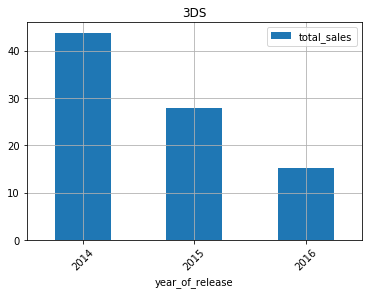

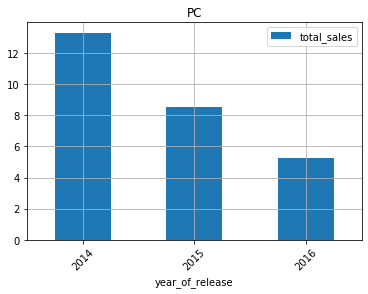

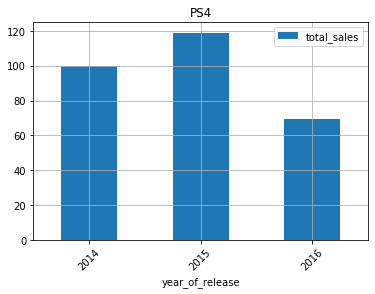

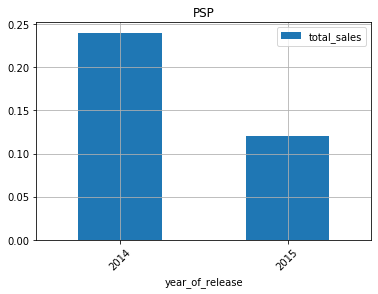

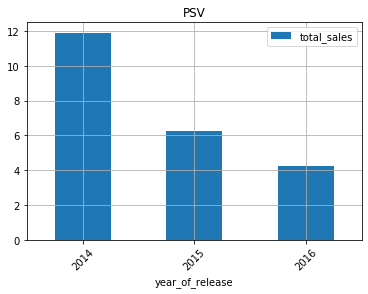

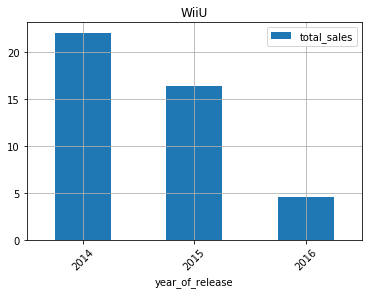

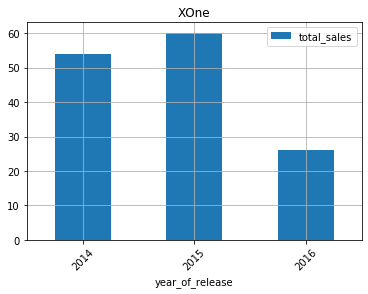

In [31]:
# построим диаграммы распределения продаж по годам
lst = ['3DS', 'PC', 'PS4', 'PSP', 'PSV', 'WiiU', 'XOne']
for i in lst:
    (df_actual_top[df_actual_top['platform'] == i]
     .plot.bar('year_of_release', 
               'total_sales', 
               figsize=(6,4), 
               title=i, 
               grid=True, 
               rot=45)
    )
plt.show()

Топ-платформы по продажам за данный период:
* PS4
* XOne

Перспективные платформы:
* PS4
* XOne

Угасающие платформы:
* 3DS
* PC
* PSP
* PSV
* WiiU

### Построение графиков «ящик с усами» по глобальным продажам игр в разбивке по платформам

In [32]:
# выделим перспективные платформы
df_growing = df_actual[df_actual['platform'].isin(('PS4', 'XOne'))]

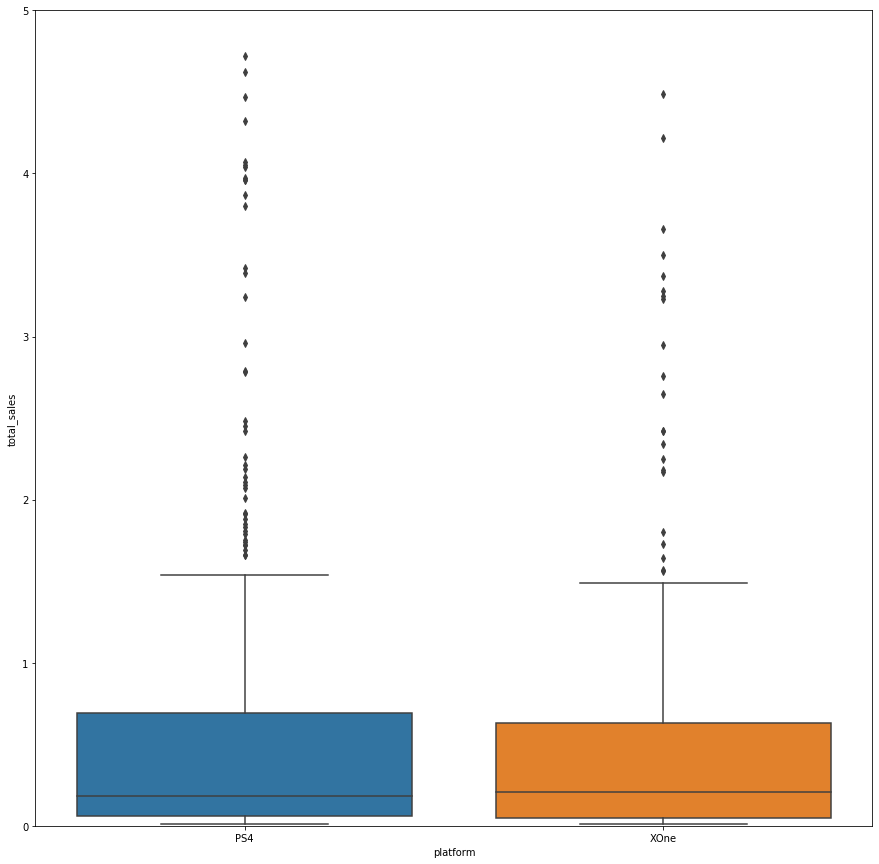

In [33]:
# построим графики "ящик с усами"
plt.figure(figsize=(15,15))
sns.boxplot(data=df_growing,
            x='platform',
            y='total_sales'
           )
plt.ylim(0, 5)
plt.show()

Графики платформ *PS4* и *Xbox One*  очень похожи. Вероятно это связано с тем, что они являются прямыми конкурентами, т.к. сами эти платформы схожи друг с другом по функционалу. 

### Влияние на продажи отзывов пользователей и критиков внутри одной популярной платформы . Построение диаграммы рассеяния и рассчет корреляции между отзывами и продажами

Для исследования возьмем платформу PS4.

In [34]:
df_ps4 = df_growing.query('platform == "PS4"')
print(f'Корреляция продажи/отзывы критиков для PS4: {df_ps4["total_sales"].corr(df_ps4["critic_score"]):.2f}')
print(f'Корреляция продажи/отзывы пользователей для PS4: {df_ps4["total_sales"].corr(df_ps4["user_score"]):.2f}')

Корреляция продажи/отзывы критиков для PS4: 0.40
Корреляция продажи/отзывы пользователей для PS4: -0.04


Результат говорит о том, что есть средняя зависимость между продажами и отзывами критиков, а зависимость между продажами и отзывами пользователей отсутствует.

Построим диаграммы рассеяния.

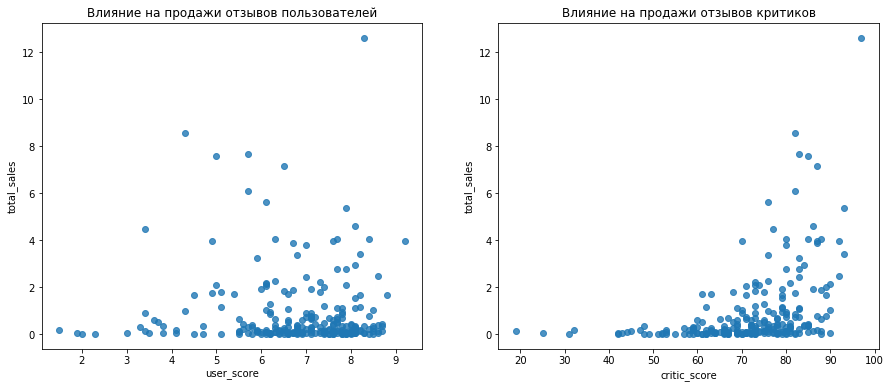

In [35]:
fig = plt.figure(figsize=(15,6))
ax_1 = fig.add_subplot(1, 2, 1)
ax_1 = sns.regplot(x=df_ps4['user_score'], y=df_ps4['total_sales'], fit_reg=False)
ax_1.set_title('Влияние на продажи отзывов пользователей')
ax_2 = fig.add_subplot(1, 2, 2)
ax_2 = sns.regplot(x=df_ps4['critic_score'], y=df_ps4['total_sales'], fit_reg=False)
ax_2.set_title('Влияние на продажи отзывов критиков')
fig.show()

Действительно между отзывами пользователей и продажами сложно найти зависимость. По диаграмме продаж и отзывов критиков можно увидить, что если рейтинг выше 60, то увеличивается количество хорошо продаваемых игр.

### Сравнение выводов с продажами игр на других платформах

In [36]:
# построим таблицу корреляции отзывов и продаж для остальных платформ за актуальный период
critic = []
user = []

for i in df_actual['platform'].unique():
    rel = df_actual[df_actual['platform'] == i]
    critic.append(rel["total_sales"].corr(rel["critic_score"]))
    user.append(rel["total_sales"].corr(rel["user_score"]))

platform = pd.DataFrame(df_actual['platform'].unique())
platform['critic'] = critic
platform['user'] = user
platform.columns = ['platform', 'critic', 'user'] 
platform = platform.round(2)
platform

,platform,critic,user
0,PS4,0.40,-0.04
1,3DS,0.31,0.22
2,XOne,0.43,-0.07
3,WiiU,0.37,0.41
4,PS3,0.45,-0.17
5,X360,0.53,-0.14
6,PC,0.17,-0.07
7,Wii,NaN,1.00
8,PSV,0.04,-0.17
9,PSP,NaN,NaN


Выводы из прошлого пункта применимы практически для всех платформ. Исключением является WiiU, у которой существует средняя зависимость между продажами и отзывами пользователей. 

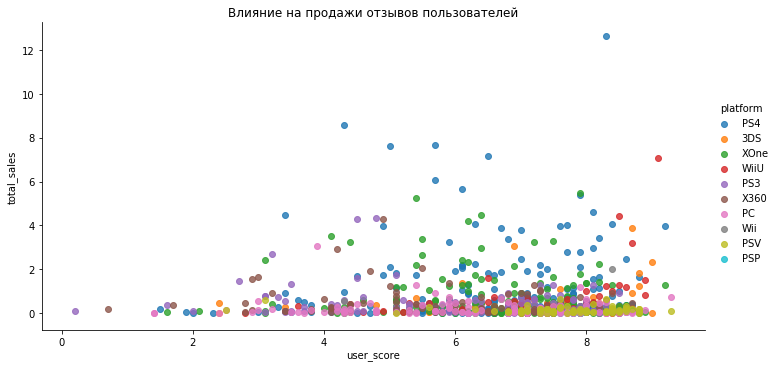

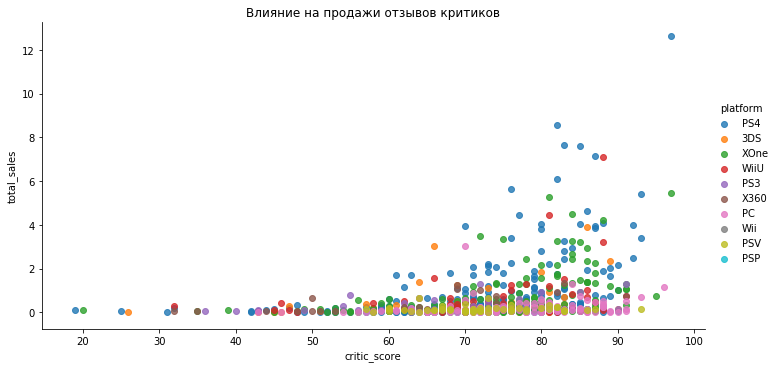

In [37]:
sns.lmplot('user_score', 'total_sales', data=df_actual, hue='platform', fit_reg=False, height=5, aspect=2)
plt.title('Влияние на продажи отзывов пользователей')
plt.show()
sns.lmplot('critic_score', 'total_sales', data=df_actual, hue='platform', fit_reg=False, height=5, aspect=2)
plt.title('Влияние на продажи отзывов критиков')
plt.show()

Графики распределения для всех платформ подобны графикам распределения для PS4.

Можно сделать вывод о том, что между продажами и отзывами критиков есть средняя прямая зависимость. Между продажами и отзывами Пользователей лишь для одной платформы (WiiU) есть средняя прямая зависимость, для остальных она отсутствует.

### Общее распределение игр по жанрам

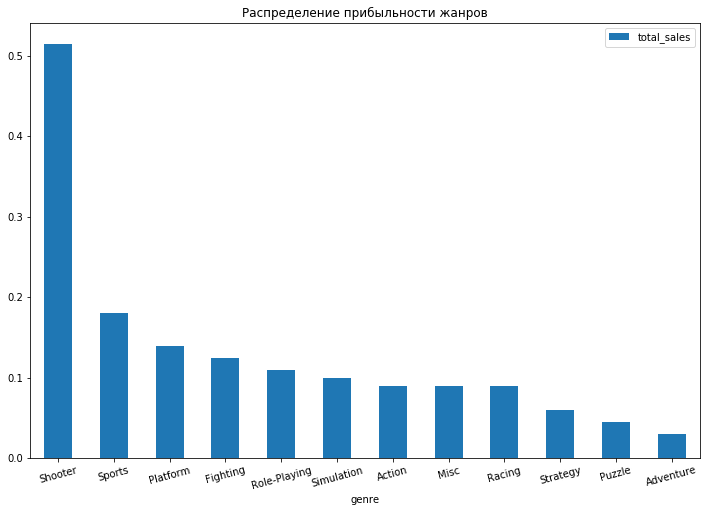

In [38]:
# по столбчатой диаграмме посмотрим на общее распределение прибыльности жанров
df_actual.pivot_table(index='genre', values='total_sales', aggfunc='median').sort_values('total_sales', ascending=False)\
.plot.bar(figsize=(12, 8), rot=15, title='Распределение прибыльности жанров')
plt.show()

Можно выделить пятерку лидеров:
* *Shooter* - лидер с большим отрывом от остальных
* *Sports*
* *Platform*
* *Fighting*
* *Role-Playing*

Самый непопулярый жанр - *Adventure*

## Портрет пользователя каждого региона

### Самые популярные платформы (топ-5)

In [39]:
for i in df.iloc[:,4:7].columns:
    display(df_actual.pivot_table(index='platform', values=i, aggfunc='sum').sort_values(i, ascending=False).head())

,na_sales
platform,
PS4,98.61
XOne,81.27
X360,28.30
3DS,22.64
PS3,22.05


,eu_sales
platform,
PS4,130.04
XOne,46.25
PS3,25.54
PC,17.97
3DS,16.12


,jp_sales
platform,
3DS,44.24
PS4,15.02
PSV,14.54
PS3,11.22
WiiU,7.31


Среди всех платформ только *PS3* занимает верхние строчки у всех регионов. При этом вкусы европейцев и жителей Северной Америки схожи. Четыре из пяти платформ совпадают. У жителей Японии совсем другие предпочтения с лидером *3DS*.

### Самые популярные жанры (топ-5)

In [40]:
for i in df.iloc[:,4:7].columns:
    display(df_actual.pivot_table(index='genre', values=i, aggfunc='sum').sort_values(i, ascending=False).head())

,na_sales
genre,
Shooter,79.02
Action,72.53
Sports,46.13
Role-Playing,33.47
Misc,15.05


,eu_sales
genre,
Action,74.68
Shooter,65.52
Sports,45.73
Role-Playing,28.17
Racing,14.13


,jp_sales
genre,
Role-Playing,31.16
Action,29.58
Fighting,6.37
Misc,5.61
Shooter,4.87


У европейцев и американцев весь топ жанров одинаков. Возможно это связано со схожей культурой. Лидеры *Action, Shooter, Sports*. У японцев похожий топ-5 но лидеры *Role-Playing, Action, Misc*.

### Влияние рейтинга ESRB на продажи в отдельном регионе

Рейтинг ESRB:
* AO (Adults only 18+) — только для взрослых
* E - everyone - для всех
* M (Mature 17+) — от 17 лет
* T (Teen) — для подростков 13-19 лет
* K-A (Kids to Adults)— для детей и взрослых
* E10+ (Everyone 10+) — для всех старше 10 лет
* EC (Early Childhood) — для детей младшего возраста
* RP (Rating pending)

In [41]:
df_actual['rating'] = df_actual['rating'].fillna('unknown')

In [42]:
for i in df.iloc[:,4:7].columns:
    display(df_actual.pivot_table(index='rating', values=i, aggfunc='sum').sort_values(i, ascending=False).head())

,na_sales
rating,
M,96.42
unknown,64.72
E,50.74
T,38.95
E10+,33.23


,eu_sales
rating,
M,93.44
unknown,58.95
E,58.06
T,34.07
E10+,26.16


,jp_sales
rating,
unknown,56.90
T,14.78
E,8.94
M,8.01
E10+,4.46


Игры для подростков и взрослых игроков продаются в больших количествах, чем для детей. Также очень велика доля игр вовсе без рейтинга (в Японии таких большинство).

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

*Нулевая гипотеза $Н_0$*: cредние пользовательские рейтинги платформ Xbox One и PC равны.<br>
*Альтернативная гипотеза $Н_1$*: cредние пользовательские рейтинги платформ Xbox One и PC не равны.

Для проверки гипотезы будем применять t-тест, т.к. выборки по рейтингам двух платформ можно считать независимыми.<br>
Чтобы понять считать ли дисперсии выборок равными посмотри на их размеры.

In [43]:
print(f'Количество отзывов о XOne: {df_actual[df_actual["platform"] == "XOne"]["user_score"].count()}')
print(f'Количество отзывов о PC: {df_actual[df_actual["platform"] == "PC"]["user_score"].count()}')

Количество отзывов о XOne: 165
Количество отзывов о PC: 122


Выборки сильно отличаются по размерам, поэтому дисперсии будет считать различными.

In [44]:
xone = df_actual[df_actual["platform"] == "XOne"]["user_score"]
pc = df_actual[df_actual["platform"] == "PC"]["user_score"]
results_1 = st.ttest_ind(xone, pc, equal_var=False, nan_policy='omit')
alpha = 0.05
print('p-значение: ', results_1.pvalue)

if results_1.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.11601398086668985
Не получилось отвергнуть нулевую гипотезу


Делаем вывод что скорее всего cредние пользовательские рейтинги платформ Xbox One и PC равны.

### Средние пользовательские рейтинги жанров Action  и Sports  разные

*Нулевая гипотеза $Н_0$*: средние пользовательские рейтинги жанров Action и Sports равны.<br>
*Альтернативная гипотеза $Н_1$*: средние пользовательские рейтинги жанров Action и Sports не равны.

Для проверки гипотезы будем применять t-тест, т.к. выборки по рейтингам двух платформ можно считать независимыми.<br>
Чтобы понять считать ли дисперсии выборок равными посмотри на их размеры.

In [45]:
print(f'Количество отзывов о Action: {df_actual[df_actual["genre"] == "Action"]["user_score"].count()}')
print(f'Количество отзывов о Sports: {df_actual[df_actual["genre"] == "Sports"]["user_score"].count()}')

Количество отзывов о Action: 297
Количество отзывов о Sports: 127


Выборки сильно отличаются по размерам, поэтому дисперсии будет считать различными.

In [46]:
action = df_actual[df_actual["genre"] == "Action"]["user_score"]
sports = df_actual[df_actual["genre"] == "Sports"]["user_score"]
results_2 = st.ttest_ind(action, sports, equal_var=False, nan_policy='omit')
alpha = 0.05
print('p-значение: ', results_2.pvalue)

if results_2.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  1.1825550382644845e-14
Отвергаем нулевую гипотезу


Делаем вывод что скорее всего средние пользовательские рейтинги жанров Action и Sports не  равны.

## Общий вывод

**После выполнения предобработки данных и проведения исседования были получены следующие результаты:**
* До 1995 года каждый год выпускалось всего несколько десятков игр. После 1995 года шел плавный рост с пиком в 2008-2009 годах. После чего было плавное снижение до 2011 года включительно и резкий спад после 2011 года. С 2012 года график находтся в боковике.
* C 1995 начался последовательный рост продаж с пиком в 2008 году (более 650 миллионов копий) и таким же плавным спадом до настоящего времени(не более 150 млн проданных копий за неполный 2016г.).
* С 2008 года идет серьезный спад продаж.
* Лидерами продаж можно выделить 6 платформ: *PS2, X360, PS3, Wii, DS, PS*.

* медианная "продолжительность жизни" платформы составляет 7 лет. 
* медианное время роста платформы до пиковых показателей продаж составляет 3 года.

**Для плана рекламной компании на грядущий год был применен следующий принцип работы с данными:**
* Актуальный период - последние 3 года.
* Перспективными считаются платформы с растущими показателями продаж. На следующий год это *`PS4 и XOne`*.

**Дополнительные выводы:**
* Между продажами и отзывами критиков есть средняя прямая зависимость. Между продажами и отзывами пользователей лишь для одной платформы (WiiU) есть средняя прямая зависимость, для остальных она отсутствует.
* Можно выделить пятерку лидеров по жанрам:
    * *Shooter* - лидер с большим отрывом от остальных
    * *Sports*
    * *Platform*
    * *Fighting*
    * *Role-Playing*
* Самый непопулярый жанр - *Puzzle*

**Портрет пользователя по регионам (Европа, Северная Америка, Япония):**
* Самые популярные платформы (топ-5):
    * Европа - *`PS4, XOne, PS3, PC, 3DS.`*
    * Северная Америка - *`PS4, XOne, X360, 3DS, PS3.`*
    * Япония - *`3DS, PS4, PSV, PS3, WiiU.`*
* Самые популярные жанры (топ-5):
    * Европа - *`Action, Shooter, Sports, Role-Playing, Racing.`*
    * Северная Америка - *`Shooter, Action, Sports, Role-Playing, Misc.`*
    * Япония - *`Role-Playing, Action, Fighting, Misc, Shooter.`*
*  Чем выше рейтинг ESRB (старше игрок), тем больше продаж.

**Результаты проверок гипотез:**
* Средние пользовательские рейтинги платформ Xbox One и PC равны.
* Средние пользовательские рейтинги жанров Action и Sports не равны.